# Example: 1D Oscillator - Part 4/4

- Author: Dr. Daning Huang
- Date: 12/09/2025

In Part 4 of this example, we explore the validation procedure in `DyMAD`.  This is particularly useful when one wants to determine the hyperparameters of the model, such as layer size and depth.  `DyMAD` provides a handy functionality that

- Sweeps over a given set of parameters
- Trains models for each combination
- Records the validation losses
- Selects the final model with the lowest validation loss.

## Preparation

To start with, let's import the necessary modules, which should be familiar now given Part 1.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import KBF
from dymad.training import WeakFormTrainer
from dymad.utils import plot_multi_trajs, TrajectorySampler

We will recycle the training data from previous parts, so no data generation here.

## Parametric Sweep

The full case file is given in {download}`lti_kbf_cv.yaml<lti_kbf_cv.yaml>`, but there is really only one new addition, a `cv` entry, as shown below.

The options specify a $3\times 3$ parameter grid, where the `koopman_dimension` in the `model` entry spans over $3, 4, 5$, and the `N` in `weak_form_params` of the `training` entry spans over $13, 15, 17$.

The `metric` of `total` means using the total validation loss as the criterion to select the best model.  One can also choose an individual loss, e.g., `metric: "dynamics"` for dynamics loss of validation, to choose the model.

In [ ]:
"""
cv:
  param_grid:
    model.koopman_dimension: [3, 4, 5]
    training.weak_form_params.N: [13, 15, 17]
  metric: "total"
"""

## Training

The training is actually identical to the regular training.  But during training, this time you would see folders such as `_c0_f0`, `_c1_f0`, etc., where `ci` indicates the `i`th parameter combination.

In [3]:
config_path = 'lti_kbf_cv.yaml'
trainer = WeakFormTrainer(config_path, KBF)
trainer.train();

Running multiple trials can be tedious, so we also offer a multi-processing option.  It is recommended to do so in a standalone script, with the following lines.  A full example is in [`scripts/linear_time_invariant/lti_mp.py`](https://github.com/apus-lab/dymad/blob/main/scripts/linear_time_invariant/lti_mp.py).

In [ ]:
"""
import torch.multiprocessing as mp

if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)  # Extra line for multi-processing

    # Case set up as usual

    # The new option, xx is the number of devices/threads that your machine can support
    trainer = WeakFormTrainer(config_path, KBF, num_workers=xx)
    trainer.train();
"""

## Visualizing Validation Results

Once the results are available, we can review the distribution of validation losses and assess the optimality of the hyperparameters.  There are several modes of plotting, as shown below.

- The first is a 2D scatter plot over both parameters, and the red box shows the best combination.
- The second collapses all trials under one parameter, so for one value of parameter there are multiple points.
- The third unrolls all trials into one axis.
- The error bar in the latter two cases would be non-zero if we specified a $k$-fold training.

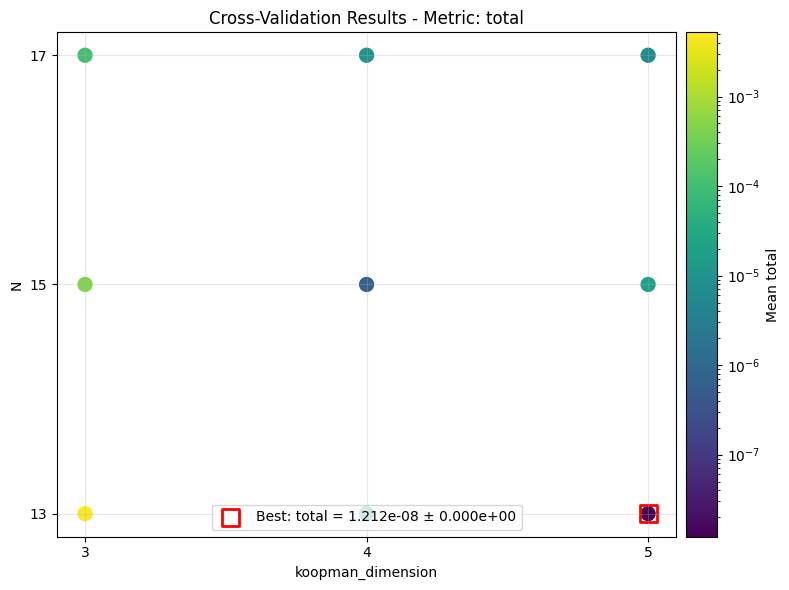

In [5]:
from dymad.utils import plot_cv_results   # New function

keys = ['model.koopman_dimension', 'training.weak_form_params.N']
plot_cv_results('lti_kbf_cv', keys, ifclose=False)

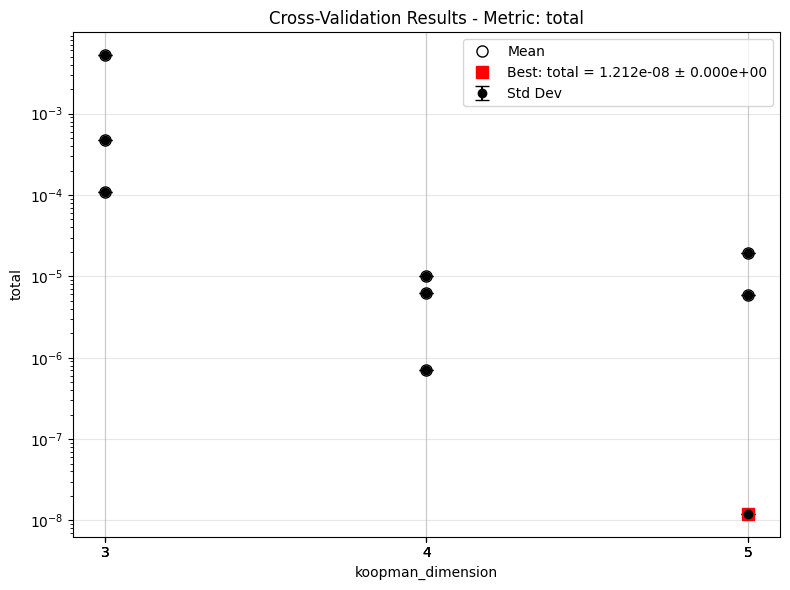

In [6]:
keys = ['model.koopman_dimension']
plot_cv_results('lti_kbf_cv', keys, ifclose=False)

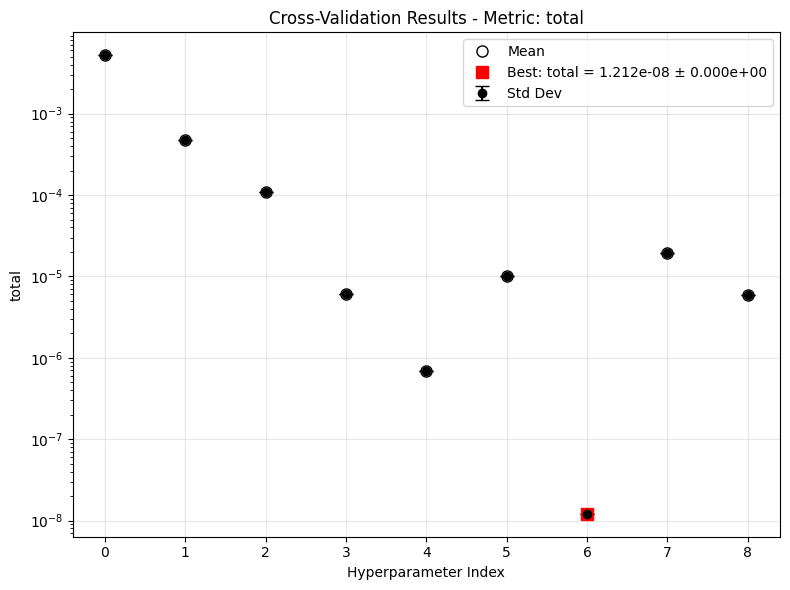

In [7]:
plot_cv_results('lti_kbf_cv', None, ifclose=False)

## Checking the Prediction

This last step should be standard practice by now.  The prediction appears fairly decent.

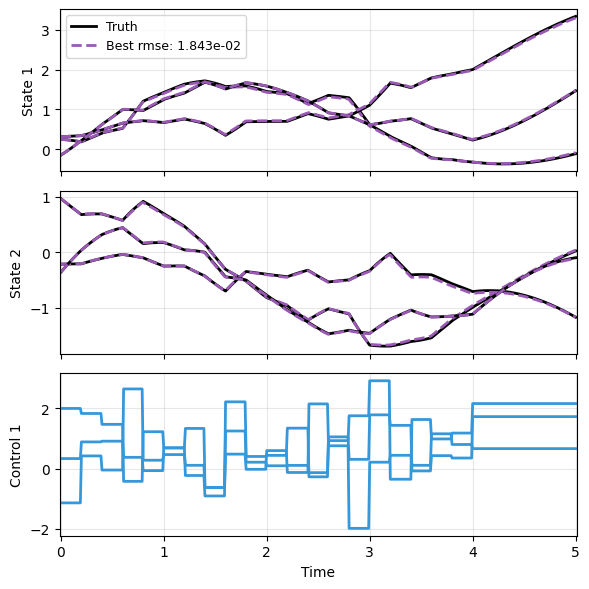

In [9]:
A = np.array([
            [0., 1.],
            [-1., -0.1]])
def f(t, x, u):
    return (x @ A.T) + u
g = lambda t, x, u: x

config_gau = {
    "control" : {
        "kind": "gaussian",
        "params": {
            "mean": 0.5,
            "std":  1.0,
            "t1":   4.0,
            "dt":   0.2,
            "mode": "zoh"}}}

t_grid = np.linspace(0, 5, 501)
sampler = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_gau)
ts, xs, us, ys = sampler.sample(t_grid, batch=3)

res = [xs]
_, prd_func = load_model(KBF, 'lti_kbf_cv.pt')
with torch.no_grad():
    _pred = prd_func(xs, ts, u=us)
res.append(_pred)

plot_multi_trajs(
    np.array(res), ts[0], "LTI",
    us=us, labels=['Truth', 'Best'], ifclose=False);